In [7]:
import numpy as np
import pandas as pd 
import os
import matplotlib.pyplot as plt

# Data Loading

In [2]:
path = "/kaggle/input/utkface-new/UTKFace/"
files = os.listdir(path)
size = len(files)
print("Total samples:",size)
print(files[0])

Total samples: 23708
26_0_2_20170104023102422.jpg.chip.jpg


In [3]:
import cv2
images = []
ages = []
genders = []
for file in files:
    image = cv2.imread(path+file,0)
    image = cv2.resize(image,dsize=(110,110))
    image = image.reshape((image.shape[0],image.shape[1],1))
    images.append(image)
    split_var = file.split('_')
    ages.append(split_var[0])
    genders.append(int(split_var[1]) )

Gender: 0 Age: 54


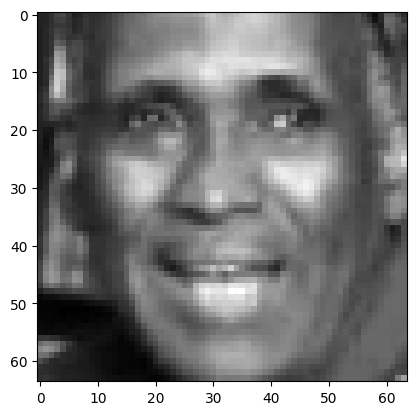

In [8]:
def display(img):
    plt.imshow(img[:,:,0])
    plt.set_cmap('gray')
    plt.show()
idx = 500
sample = images[idx]
print("Gender:",genders[idx],"Age:",ages[idx])
display(sample)

# Data Preprocessing

In [5]:
def age_group(age):
    if age >=0 and age < 4:
        return 1
    elif age < 8:
        return 2
    elif age < 15:
        return 3
    elif age < 25:
        return 4
    elif age < 38:
        return 5
    elif age < 48:
        return 6
    elif age < 60:
        return 7
    else:
        return 8

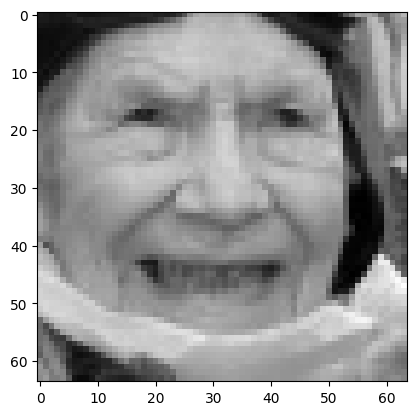

In [9]:
target = np.zeros((size,2),dtype='float32')
features = np.zeros((size,sample.shape[0],sample.shape[1],1),dtype = 'float32')
for i in range(size):
    target[i,0] = age_group(int(ages[i])) / 8
    target[i,1] = int(genders[i])
    features[i] = images[i]
features = features / 255
display(features[550])

In [10]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2,shuffle  = True)
print("Samples in Training:",x_train.shape[0])
print("Samples in Testing:",x_test.shape[0])

Samples in Training: 18966
Samples in Testing: 4742


# Data Processing

# Deep Convolutional Neural Network

In [22]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation, concatenate

# Khởi tạo mô hình Sequential
model = Sequential()

# Layer 1: Convolutional Layer
# 110x110x1 -> 112x112x5
model.add(Conv2D(5, (7, 7), strides=(4, 4), padding='same', input_shape=(110, 110, 1)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same'))
model.add(Dropout(0.5))

# Layer 2: Convolutional Layer
model.add(Conv2D(64, (5, 5), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same'))
model.add(Dropout(0.5))

# Layer 3: Convolutional Layer
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same'))
model.add(Dropout(0.5))

# Layer 4: Convolutional Layer
model.add(Conv2D(256, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same'))
model.add(Dropout(0.5))

# Layer 5: Convolutional Layer
model.add(Conv2D(512, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same'))
model.add(Dropout(0.5))

# Common layers for age and gender models
common_layers = Flatten()(model.output)
common_layers = Dense(512)(common_layers)
common_layers = Activation('relu')(common_layers)
common_layers = BatchNormalization()(common_layers)
common_layers = Dropout(0.5)(common_layers)

# Age model
age_output = Dense(1, activation='linear', name='age_output')(common_layers)

# Gender model
gender_output = Dense(1, activation='sigmoid', name='gender_output')(common_layers)

# Create the final model
final_model = Model(inputs=model.input, outputs=[age_output, gender_output])
final_model.compile(optimizer='adam', loss=['mse', 'binary_crossentropy'], metrics=['accuracy'])


In [23]:
h = final_model.fit(x_train,[y_train[:,0],y_train[:,1]],validation_data=(x_test,[y_test[:,0],y_test[:,1]]),epochs = 25, batch_size=128,shuffle = True)

Epoch 1/25
149/149 [==============================] - 88s 565ms/step - loss: 2.4618 - age_output_loss: 1.6032 - gender_output_loss: 0.8586 - age_output_accuracy: 0.0593 - gender_output_accuracy: 0.5297 - val_loss: 0.8182 - val_age_output_loss: 0.1190 - val_gender_output_loss: 0.6992 - val_age_output_accuracy: 0.0000e+00 - val_gender_output_accuracy: 0.5228
Epoch 2/25
149/149 [==============================] - 83s 555ms/step - loss: 1.0610 - age_output_loss: 0.3225 - gender_output_loss: 0.7385 - age_output_accuracy: 0.0652 - gender_output_accuracy: 0.5489 - val_loss: 0.8082 - val_age_output_loss: 0.0618 - val_gender_output_loss: 0.7464 - val_age_output_accuracy: 0.1010 - val_gender_output_accuracy: 0.5228
Epoch 3/25
149/149 [==============================] - 84s 562ms/step - loss: 0.8219 - age_output_loss: 0.1340 - gender_output_loss: 0.6879 - age_output_accuracy: 0.0706 - gender_output_accuracy: 0.5900 - val_loss: 0.7942 - val_age_output_loss: 0.0629 - val_gender_output_loss: 0.7313 - 

In [31]:
final_model.save('/kaggle/working/model.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


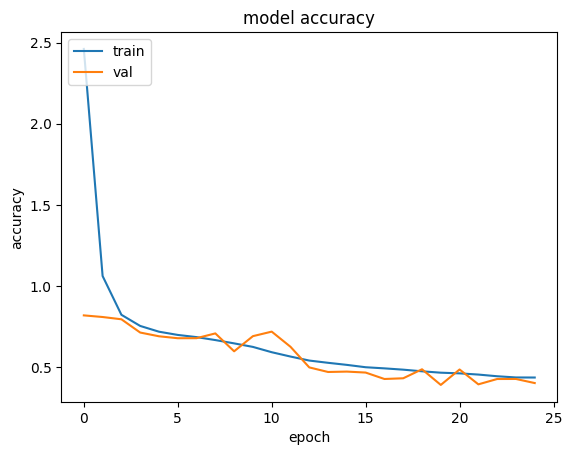

In [25]:
history = h
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

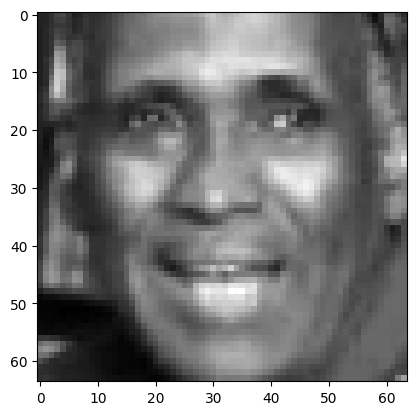

Actual Gender: Male Age: 54
1/1 [==============================] - 0s 22ms/step
Values: [array([[0.8205853]], dtype=float32), array([[0.2988963]], dtype=float32)] 
Predicted Gender: Male Predicted Age: 48-59


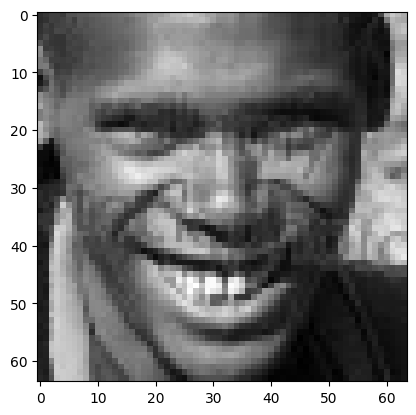

Actual Gender: Male Age: 23
1/1 [==============================] - 0s 22ms/step
Values: [array([[0.8618955]], dtype=float32), array([[0.45665896]], dtype=float32)] 
Predicted Gender: Male Predicted Age: 48-59


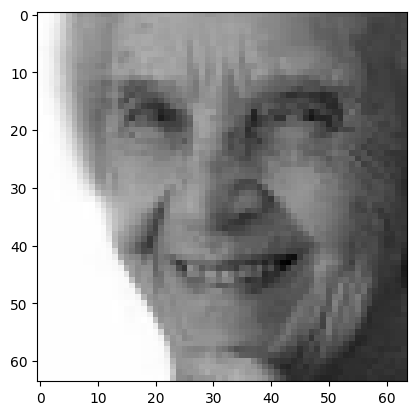

Actual Gender: Female Age: 79
1/1 [==============================] - 0s 22ms/step
Values: [array([[0.8526564]], dtype=float32), array([[0.4269643]], dtype=float32)] 
Predicted Gender: Male Predicted Age: 48-59


In [28]:
def display(img):
    plt.imshow(img[:,:,0])
    plt.set_cmap('gray')
    plt.show()

def get_age(score):
    score = score*8
    if score >=0.5 and score < 1.5:
        return "0-3"
    elif score < 2.5:
        return "4-7"
    elif score < 3.5:
        return "8-14"
    elif score < 4.5:
        return "15-24"
    elif score < 5.5:
        return "25-37"
    elif score < 6.5:
        return "38-47"
    elif score < 7.5:
        return "48-59"
    elif score < 8.5:
        return "60+"
    else:
        return "Unknown"
    
def get_gender(prob):
    if prob < 0.5:return "Male"
    else: return "Female"

def get_result(sample):
    sample = sample/255
    val = final_model.predict( np.array([ sample ]) )    
    age = get_age(val[0])
    gender = get_gender(val[1])
    print("Values:",val,"\nPredicted Gender:",gender,"Predicted Age:",age)
    
    
indexes = [500, 41, 45]
for idx in indexes:
    sample = images[idx]
    display(sample)
    print("Actual Gender:",get_gender(genders[idx]),"Age:",ages[idx])
    res = get_result(sample)

In [34]:
y_test[: 10 ,0]


array([0.625, 1.   , 0.875, 1.   , 0.875, 0.75 , 0.625, 0.875, 0.625,
       0.875], dtype=float32)

In [38]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
import numpy as np

# Assuming you have test data and labels
test_data = x_test  # Your test data
age_true_labels = y_test[:, 0]
gender_true_labels = y_test[:, 1]

# Make predictions using the final_model
age_predictions, gender_predictions = final_model.predict(test_data)

# Convert probabilities to class labels for gender
gender_predicted_labels = np.round(gender_predictions).flatten()

# Convert continuous age values to discrete categories
age_true_labels_discrete = np.round(age_true_labels * 8).astype(int)
age_predictions_discrete = np.round(age_predictions.flatten() * 8).astype(int)

# Calculate accuracy, precision, recall, and confusion matrix for age
age_accuracy = accuracy_score(age_true_labels_discrete, age_predictions_discrete)
age_precision = precision_score(age_true_labels_discrete, age_predictions_discrete, average='weighted')
age_recall = recall_score(age_true_labels_discrete, age_predictions_discrete, average='weighted')
age_conf_matrix = confusion_matrix(age_true_labels_discrete, age_predictions_discrete)

# Calculate accuracy, precision, recall, and confusion matrix for gender
gender_accuracy = accuracy_score(gender_true_labels, gender_predicted_labels)
gender_precision = precision_score(gender_true_labels, gender_predicted_labels)
gender_recall = recall_score(gender_true_labels, gender_predicted_labels)
gender_conf_matrix = confusion_matrix(gender_true_labels, gender_predicted_labels)

# Print or use the calculated metrics as needed
print("Age Metrics:")
print("Accuracy:", age_accuracy)
print("Precision:", age_precision)
print("Recall:", age_recall)
print("Confusion Matrix:\n", age_conf_matrix)

print("\nGender Metrics:")
print("Accuracy:", gender_accuracy)
print("Precision:", gender_precision)
print("Recall:", gender_recall)
print("Confusion Matrix:\n", gender_conf_matrix)


149/149 [==============================] - 2s 12ms/step
Age Metrics:
Accuracy: 0.25390130746520456
Precision: 0.30968666968650543
Recall: 0.25390130746520456
Confusion Matrix:
 [[  0   0   0   0   0   0   0   0   0]
 [  2  37 129 107  49  27  15   5   0]
 [  0   2  12  25  37  39   7   4   0]
 [  0   0   4   8  29 118  38  26   0]
 [  0   0   0   4  73 333 100 142   0]
 [  0   0   0   2 142 652 319 698   0]
 [  0   0   0   0  16 109 101 289   0]
 [  0   0   0   0  22  95  77 321   0]
 [  0   0   0   2  11  90  90 334   0]]

Gender Metrics:
Accuracy: 0.8281315900463939
Precision: 0.7675535846267554
Recall: 0.9178082191780822
Confusion Matrix:
 [[1850  629]
 [ 186 2077]]


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# một vài cải tiến nếu có thời gian
# - thay thế các optimizer trong model để xem optimizer nào có độ chính xác cao hơn
# - lập các bảng composition of sét by age, gender: https://arxiv.org/pdf/2110.12633.pdf
# - vẽ epoch 
